## Persistent

In [42]:
import sys
import time
import re
import random
import itertools
import pprint
import math
import psutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from collections import defaultdict
from typing import Tuple, List, Set, Callable, NamedTuple, Union, Optional, Iterable, Dict
from multiprocessing import Pool

plt.rcParams['savefig.format'] = 'svg'
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (12, 12)


In [43]:
CPU_CORES = 16

In [44]:
class Point(NamedTuple):
    """An integer point in 2D space."""
    x: int
    y: int

In [45]:
class Line:
    """
    Represents a line defined by a rational slope and a point on the line.

    Attributes:
        slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
        point (Point): An arbitrary point on the line.
        a (QQ): Coefficient of x in the standard form.
        b (QQ): Coefficient of y in the standard form.
        c (QQ): Constant term in the standard form.
        points (Set[Point]): Set of integer-coordinate points on the line within the grid.
    """

    def __init__(self, slope: Union[QQ, str], point: Point, grid_size: int = 100):
        """
        Initialize a line with a given slope and a point on the line.

        Args:
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
            point (Point): A point on the line.
            grid_size (int): Maximum grid coordinate (inclusive).
        """
        self.slope = slope
        self.point = point

        x0, y0 = point.x, point.y
        if slope == 'inf':
            self.a = QQ(1)
            self.b = QQ(0)
            self.c = -QQ(x0)
            self.points = {Point(x0, y) for y in range(1, grid_size + 1) if 1 <= x0 <= grid_size}
        else:
            m = slope
            self.a = -m
            self.b = QQ(1)
            self.c = m * x0 - y0
            b = QQ(y0) - m * QQ(x0)
            self.points = {
                Point(x, int(y))
                for x in range(1, grid_size + 1)
                if (y := m * QQ(x) + b).denominator() == 1 and 1 <= int(y) <= grid_size
            }

    @classmethod
    def from_points(cls, p1: Point, p2: Point, grid_size: int = 100) -> 'Line':
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        if dx == 0:
            slope = 'inf'
        else:
            slope = QQ(dy) / QQ(dx)
        return cls(slope, p1, grid_size)

    @classmethod
    def from_point_slope_of_line(cls, p: Point, slope: Union[QQ, str], grid_size: int = 100) -> 'Line':
        return cls(slope, p, grid_size)

    @classmethod
    def from_standard_form(cls, a: QQ, b: QQ, c: QQ, grid_size: int = 100) -> 'Line':
        if b == 0:
            slope = 'inf'
            point = Point(-c / a, QQ(0))
        else:
            slope = -a / b
            point = Point(QQ(0), -c / b)
        return cls(slope, point, grid_size)


In [46]:
line = Line.from_points(Point(2, 3), Point(5, 7), grid_size=20)
line.points

{Point(x=2, y=3),
 Point(x=5, y=7),
 Point(x=8, y=11),
 Point(x=11, y=15),
 Point(x=14, y=19)}

In [47]:
def are_collinear(p1: Point, p2: Point, p3: Point) -> bool:
    """
    Determine if three points are collinear.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).
        p3 (Point): The third point as a named tuple with integer coordinates (x, y).

    Returns:
        bool: True if the three points are collinear, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

In [48]:
def plot_points(points: Iterable[tuple], n: Optional[int] = None, title: str = "Points Plot", zero_index: bool = False):
    """
    Plot a set of points on an n x n grid.

    Args:
        points (Iterable[Tuple[int, int]]): Iterable of points to plot.
        n (Optional[int]): Grid size. If None, inferred from points.
        title (str): Title of the plot.
        zero_index (bool): If True, axes range from 0 to p-1. If False, from 1 to p.

    Returns:
        None
    """
    points = list(points)
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    offset = 0 if zero_index else 1
    if n is None:
        n = max(max(xs), max(ys)) + 1

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    ax.set_xticks(range(offset, n + 1))
    ax.set_yticks(range(offset, n + 1))

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(offset - 1, n if zero_index else n + 1)
    ax.set_ylim(offset - 1, n if zero_index else n + 1)

    return fig, ax


In [49]:
def plot_lines(points: Iterable[Point], n: Optional[int] = None, title: str = "Lines Plot") -> None:
    """
    Plot a set of points and the lines connecting them on an n x n grid.

    Args:
        points (Iterable[Point]): Iterable of points to plot.
        n (Optional[int]): Grid size. If None, inferred from points.
        title (str): Title of the plot.

    Returns:
        None
    """
    xs, ys = zip(*[(pt.x, pt.y) for pt in points])
    plt.scatter(xs, ys, s = 30, color='black')

    remaining = {Point(x, y) for x in range(1, n + 1) for y in range(1, n + 1)}

    
    seen_lines = set()

    for p1, p2 in itertools.combinations(points, 2):
        line = Line.from_points(p1, p2, grid_size=n)
        key = (line.a, line.b, line.c)
        if key in seen_lines:
            continue
        seen_lines.add(key)

        lattice_pts = line.points

        for pt in lattice_pts:
            plt.scatter(pt.x, pt.y, color='red', s=10)
        remaining.difference_update(lattice_pts)

        
        pts = []
        a, b, c = line.a, line.b, line.c
        if b: pts += [(0, float(-c/b))] if 0 <= -c/b <= n+1 else []
        if b: pts += [(n+1, float((-a*(n+1)-c)/b))] if 0 <= (-a*(n+1)-c)/b <= n+1 else []
        if a: pts += [(float(-c/a), 0)] if 0 <= -c/a <= n+1 else []
        if a: pts += [(float((-b*(n+1)-c)/a), n+1)] if 0 <= (-b*(n+1)-c)/a <= n+1 else []
        x_vals, y_vals = zip(*pts)
        plt.plot(x_vals, y_vals, color='gray', linewidth=0.5)
    

    """
    if remaining:
        rx, ry = zip(*[(pt.x, pt.y) for pt in remaining])
        plt.scatter(rx, ry, color='green', s=30, zorder=3)
"""
    plt.gca().set_aspect('equal')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(range(1, n + 1))
    plt.yticks(range(1, n + 1))
    plt.show()


In [50]:
def greedy(n: int, priority: Callable[[Point], float]):
    """
    Select points greedily from an n x n grid based on a priority function,
    ensuring no three selected points are pure_random

    Args:
        n (int): The dimension of the grid (points range from 0 to n-1 in both x and y).
        priority (Callable[[Point], float]): A function assigning a priority score to each point.

    Returns:
        List[Point]: Sorted list of selected points.
    """
    grid: List[Point] = [Point(x, y) for x in range(1, n+1) for y in range(1, n+1)]
    shuffle(grid)

    priorities = {p: priority(p) for p in grid}
    candidates: Set[Point] = set(grid)
    selected: Set[Point] = set()

    removals = []


    while candidates:

        p = max(candidates, key=lambda pt: priorities[pt])
        candidates -= {p}

        banned = {
            q
            for s in selected 
            for q in Line.from_points(p, s, n).points
        }
        # print(banned & candidates)

        candidates = candidates - banned

        selected.add(p)
        removals.append(len(candidates) / n**2 * 1.0)
    removals = [(i / (2.0*n), removals[i]) for i in range(len(removals))]
    return removals




In [51]:
def pure_random_priority(n):
    def priority(point):
        return 0
    return priority


In [52]:
removals = greedy(10, pure_random_priority(10))

removals

[(0.000000000000000, 0.990000000000000),
 (0.0500000000000000, 0.960000000000000),
 (0.100000000000000, 0.930000000000000),
 (0.150000000000000, 0.740000000000000),
 (0.200000000000000, 0.660000000000000),
 (0.250000000000000, 0.630000000000000),
 (0.300000000000000, 0.560000000000000),
 (0.350000000000000, 0.350000000000000),
 (0.400000000000000, 0.270000000000000),
 (0.450000000000000, 0.180000000000000),
 (0.500000000000000, 0.120000000000000),
 (0.550000000000000, 0.0900000000000000),
 (0.600000000000000, 0.0500000000000000),
 (0.650000000000000, 0.0200000000000000),
 (0.700000000000000, 0.0100000000000000),
 (0.750000000000000, 0.000000000000000)]

In [53]:
def plot_efficiency(data):
    x, y = zip(*data)
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, marker='o', linestyle='-')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot of Points with Connecting Lines')
    plt.grid(True)
    plt.show()

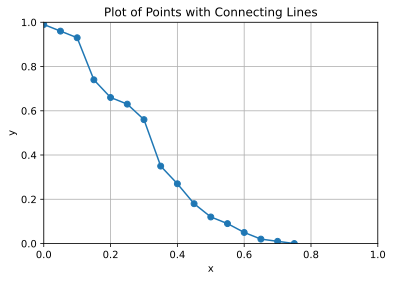

In [54]:
plot_efficiency(removals)

## Priorities

In [55]:
def pure_random_priority(n):
    def priority(point):
        return 0
    return priority


In [56]:
priority_functions = {
    'pure_random' : pure_random_priority,
}
@parallel(ncpus=CPU_CORES)
def run_greedy_for_strategy(n, strategy_name):
    priority_func = priority_functions[strategy_name](n)
    result = greedy(n, priority_func)
    print(f"Done greedy for n={n} with strategy {strategy_name}, len(result)={len(result)}")
    return (n, result)


In [99]:
lb = 100
ub = 400

step = 10

In [100]:
inputs = [(n, 'pure_random') for n in range(lb, ub+1, step)]

results_pure_random = run_greedy_for_strategy(inputs)


results_pure_random = [res for (_, res) in results_pure_random]


results_pure_random = [res[:2] for res in results_pure_random]



Done greedy for n=100 with strategy pure_random, len(result)=145
Done greedy for n=110 with strategy pure_random, len(result)=156
Done greedy for n=120 with strategy pure_random, len(result)=180
Done greedy for n=130 with strategy pure_random, len(result)=189
Done greedy for n=160 with strategy pure_random, len(result)=234
Done greedy for n=140 with strategy pure_random, len(result)=203
Done greedy for n=170 with strategy pure_random, len(result)=245
Done greedy for n=150 with strategy pure_random, len(result)=219
Done greedy for n=180 with strategy pure_random, len(result)=261
Done greedy for n=200 with strategy pure_random, len(result)=287
Done greedy for n=210 with strategy pure_random, len(result)=305
Done greedy for n=190 with strategy pure_random, len(result)=273
Done greedy for n=220 with strategy pure_random, len(result)=312
Done greedy for n=230 with strategy pure_random, len(result)=329
Done greedy for n=250 with strategy pure_random, len(result)=356
Done greedy for n=240 wit

In [107]:
results = {
    'saturation': results_pure_random,
}

In [108]:
print(results)

{'saturation': [(100, [(0.000000000000000, 0.999900000000000), (0.00500000000000000, 0.999800000000000), (0.0100000000000000, 0.999200000000000), (0.0150000000000000, 0.998900000000000), (0.0200000000000000, 0.997000000000000), (0.0250000000000000, 0.992600000000000), (0.0300000000000000, 0.981500000000000), (0.0350000000000000, 0.975500000000000), (0.0400000000000000, 0.974200000000000), (0.0450000000000000, 0.971200000000000), (0.0500000000000000, 0.955100000000000), (0.0550000000000000, 0.944000000000000), (0.0600000000000000, 0.924100000000000), (0.0650000000000000, 0.919500000000000), (0.0700000000000000, 0.915400000000000), (0.0750000000000000, 0.892800000000000), (0.0800000000000000, 0.878500000000000), (0.0850000000000000, 0.863800000000000), (0.0900000000000000, 0.844000000000000), (0.0950000000000000, 0.834500000000000), (0.100000000000000, 0.830900000000000), (0.105000000000000, 0.813600000000000), (0.110000000000000, 0.801300000000000), (0.115000000000000, 0.786000000000000

In [115]:
def plot_multiple_series(data_dict):
    plt.figure(figsize=(15, 12))
    for label, series_list in data_dict.items():
        for n, points in series_list:
            if n < 200:
                continue
            x, y = zip(*points)
            y = [1 - val for val in y]            
            plt.plot(x, y, marker='o', linestyle='-', label=f'n={n}')
            # plt.plot(x, y, marker='o', linestyle='-')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Saturations')
    plt.legend()
    plt.grid(True)
    plt.show()

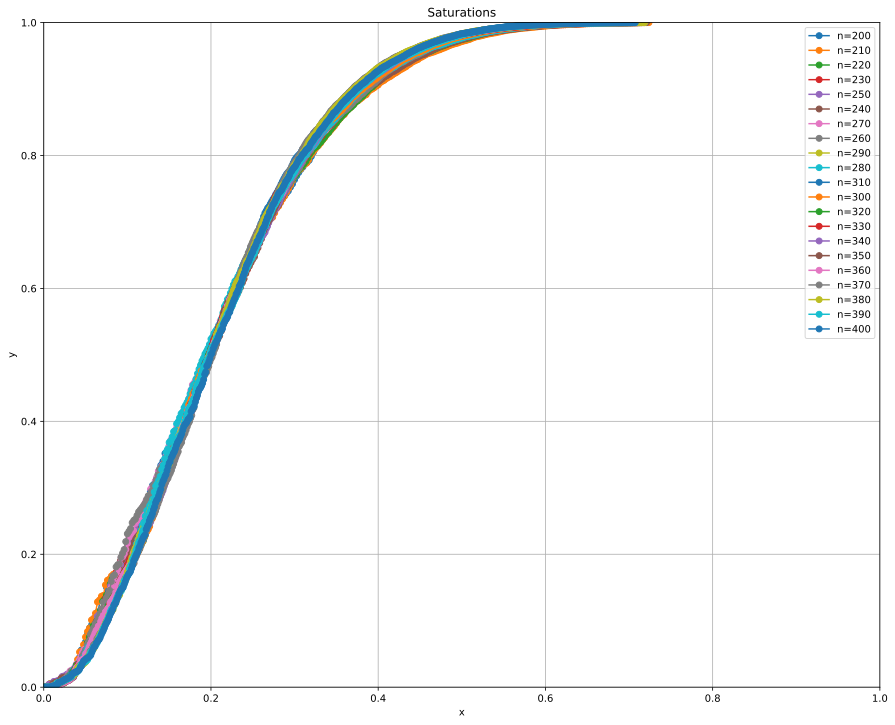

In [116]:
plot_multiple_series(results)